# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


# Vanilla Autoencoder (3 балла)

## Prepare the data


In [1]:
!pip install Pillow

In [2]:
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 101kB/s 
ERROR: umap-learn 0.4.4 has requirement scipy>=1.3.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [3]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from copy import deepcopy
import torch.utils.data as data_utils
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [4]:
import os
from scipy.misc.pilutil import imread,imresize
import pandas as pd

def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: imresize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs

In [5]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
# from get_dataset_correct import fetch_dataset
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [6]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
# у нас цветные изображения
N_CHANNELS = 3

TRAIN_SIZE = 10000
VAL_SIZE = data.shape[0] - TRAIN_SIZE


Разбейте выборку картинок на train и val и приведите значения элементов в интервал [0, 1] типа float

In [7]:
class AutoEncode(Dataset):
  def __init__(self, data):
    super().__init__()
    self.data = data
    self.len_ = len(data)


  def __len__(self):
        return self.len_

  def __getitem__(self, index):
    transform = transforms.Compose([
            transforms.ToTensor(),
        ])
    X = np.array(self.data[index]/255., dtype = 'float32')
    return transform(X)

In [8]:
X_train, X_val = train_test_split(data, train_size=TRAIN_SIZE)
print(X_train.shape, X_val.shape)
X_train = AutoEncode(X_train)
X_val = AutoEncode(X_val)

(10000, 45, 45, 3) (3143, 45, 45, 3)


In [9]:
data = data.transpose(0, 3, 1, 2) #переводим в тензорный вид (batch, C, H, W)
transform = transforms.ToTensor()
X_train = np.float32(data[:10000]/255.) # приводим к [0, 1], transforms.ToTensor() сделает это все за нас
X_val = np.float32(data[10000:]/255.)

Посмотрим первые 5 аттрибутов

In [10]:
attrs.head()

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.56835,-1.88904,1.7372,-0.929729,-1.4718,-0.19558,-0.835609,-0.351468,-1.01253,-0.719593,-0.632401,0.464839,-0.973528,1.56519,-1.2967,-1.54272,-0.684671,-0.86499,0.766886,-0.218952,-1.65567,-0.787044,-0.599665,0.458519,0.18976,0.851555,-0.38572,-0.497719,-0.161149,-0.257514,-0.0888388,0.455469,-0.839211,-0.0229481,-0.922568,-0.114539,1.46122,1.75848,0.0688935,1.26786,-1.12024,0.917617,-1.30796,-1.50041,1.02922,0.832363,-0.498657,0.251365,-0.705281,-0.515715,0.374239,-0.168675,-0.614143,3.0977,1.52386,0.779278,-0.0714539,-1.24648,-0.769283,-0.725597,-1.82061,-2.07298,-0.960759,0.361738,1.16612,-1.16492,-1.13999,-2.37175,-1.29993,-0.414682,-1.1449,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.28218,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,-0.736883,0.294554,-1.27765,0.954771,-0.990992,-1.16736,-0.835146,0.798544,-0.971679,0.342826,-1.32256,0.962937,-1.19936,-0.157307,0.443224,-0.00288156,-0.0211584,-0.226563,-0.0810386,-0.827202,-0.106624,1.22759,-0.812223,-1.24126,0.0962725,-0.404544,0.325919,0.474452,1.13536,0.0587247,0.611176,-1.17251,0.428512,-0.874235,-1.19156,0.192359,-0.204166,0.342347,0.239512,-1.47469,0.236057,-0.565208,-0.712542,2.99708,-0.273306,-0.187722,-0.604608,-1.3217,-0.938559,0.494294,-0.659043,-1.14375,-0.775722,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.00624408,-0.0304057,-0.480128,0.66676,-0.496559
2,0.997749,-1.36419,-0.157377,-0.756447,-1.89183,-0.871526,-0.862893,0.0314447,-1.34152,-0.0900375,-1.20073,-0.33246,-0.537006,1.29836,-1.49847,-1.28582,1.14174,0.172817,0.106412,-0.788843,0.349295,-1.64372,0.454287,1.18946,-0.688414,-0.590574,-0.266673,0.467224,0.567348,-1.7191,0.124667,1.60274,-0.659399,-1.75376,1.20447,0.0221884,-1.13544,1.70286,-0.422144,0.587859,0.414363,0.344447,-1.26045,-0.577746,0.405567,-1.91655,0.92126,0.247437,-0.428451,-0.772273,0.370673,-0.509596,-0.768482,1.7069,0.126524,-0.497001,-0.393042,-0.178307,-1.18023,-0.596914,-1.80538,-0.951643,-0.838087,1.54974,1.88475,-0.999765,-1.35986,-1.91211,-1.09563,0.915126,-0.572332,0.144262,-0.841231
3,1.12272,-1.9978,1.91614,-2.51421,-2.58007,-1.40424,0.0575511,0.000195882,-1.27351,-1.43146,-0.0705188,-0.339239,-2.00415,0.665695,-0.77594,-1.47163,-1.17908,0.563327,-0.664429,-1.40793,0.435594,-0.589988,-1.6035,1.17074,0.760103,0.211498,-0.51618,-1.33115,0.20284,0.149645,-0.0464296,0.640885,-0.107616,-0.831271,-0.827005,-0.588725,0.429255,1.58766,0.499086,-0.0568692,-0.866643,-0.959689,0.35073,-1.33535,-0.42789,0.826817,-0.256779,0.149751,-1.20153,-1.08392,0.255363,-0.650423,-0.506293,1.10159,0.640783,1.57503,-0.484397,-1.55968,-1.43712,0.379363,-0.648233,-2.25735,-1.07561,0.567822,-0.176089,1.10812,-1.60094,-3.26461,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.07821,-2.0081,1.67621,-2.27806,-2.65185,-1.34841,0.649089,0.0176564,-1.88911,-1.85721,-0.568057,0.840375,-1.98127,1.66671,-0.910723,-1.99351,-0.871335,0.507786,-0.488947,-0.88649,-0.990132,-0.750813,-0.378479,0.583086,-1.4796,0.250185,-0.381123,-0.611991,-0.143091,-1.07276,0.432094,1.08919,-0.470929,-1.17712,-0.111313,-0.154603,-1.03151,2.39246,-0.191576,1.2279,-1.3818,-1.52885,0.907964,-1.32429,-0

Напишем вспомогательную функцию, которая будет выводить n_row $\cdot$ n_col первых картинок в массиве images:

In [11]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest') #для отрисовки тензора перевести к numpy
            plt.xticks(())
            plt.yticks(())
        except:
            pass

Осталось привести картинки к тензорам из PyTorch, чтобы можно было потом скармливать их автоэнкодеру: 

In [12]:
#X_train = torch.FloatTensor(X_train)
#X_val = torch.FloatTensor(X_val)
train_loader = DataLoader(X_train, batch_size=64, shuffle=True) # дата решафлится каждую эпоху
val_loader = DataLoader(X_val, batch_size=64, shuffle=False)

In [13]:
next(iter(train_loader)).shape

torch.Size([64, 3, 45, 45])

In [14]:
type(X_train)

numpy.ndarray

## Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:
<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

In [15]:
inp_size=X_train.shape[1]
hid_size=250
dimZ = 100

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [16]:

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        #на вход (3, 45, 45) выход (6, 45, 45)
        self.conv1_down = nn.Sequential(nn.Conv2d(3, 20, 3, padding=1),
                                        nn.BatchNorm2d(20),
                                        nn.LeakyReLU(0.2)
        )
        self.conv2_down = nn.Sequential(nn.Conv2d(20, 40, 3),
                                        nn.BatchNorm2d(40),
                                        nn.LeakyReLU(0.2),
                                        nn.MaxPool2d(2) #21
        ) 
        self.conv3_down = nn.Sequential(nn.Conv2d(40, 60, 3), #19
                                        nn.BatchNorm2d(60),
                                        nn.LeakyReLU(0.2),
        )
        self.pool = nn.MaxPool2d(2) #9
        self.fc1 = nn.Linear(60*9*9, 250)
        #выход 250
        self.fc2 = nn.Sequential(nn.Linear(250, 60*9*9),
                                 nn.LeakyReLU(0.2)
        )
        self.conv3_up = nn.Sequential(nn.ConvTranspose2d(60, 40, 3, stride=2),# формула size+(size-1) + (pad)*2 - (kernel-1), где pad = 0, если padding=2, 1, если 1, 2, если 0 и еще padding зависит от kernel (pad = 2 для 3, pad=3 для 4)
                                      nn.LeakyReLU(0.2),
                                      nn.Conv2d(40, 40, 3, padding=1),
                                      nn.BatchNorm2d(40),
                                      nn.LeakyReLU(0.2)

        )
        self.conv2_up = nn.Sequential(nn.ConvTranspose2d(40, 20, 3, stride = 1),
                                      nn.BatchNorm2d(20),
                                      nn.LeakyReLU(0.2),
                                      nn.Conv2d(20, 20, 3, padding=1),
                                      nn.BatchNorm2d(20),
                                      nn.LeakyReLU(0.2)
        )
        self.conv1_up = nn.Sequential(nn.ConvTranspose2d(20, 3, 3, stride=2),
                                      nn.BatchNorm2d(3),#batchnorm после relu попробовать
                                      nn.LeakyReLU(0.2),
                                      nn.Conv2d(3, 3, 3, padding=2),
                                      nn.BatchNorm2d(3),
                                      nn.LeakyReLU(0.2)
        )


    def encoder_(self, x):
        self.conv1 = self.conv1_down(x)
        self.conv2 = self.conv2_down(self.conv1)
        self.conv3 = self.conv3_down(self.conv2)
        latent_code = self.fc1(self.pool(self.conv3).view(x.size(0), -1))
        return latent_code


    def decoder_(self, z):
        z = self.fc2(z).view(-1, 60, 9, 9)
        z = self.conv3_up(z)
        z = self.conv2_up(z)
        z = self.conv1_up(z)
        reconstruct = torch.sigmoid(z) 
        return reconstruct   

    def forward(self, x):
        encoder = self.encoder_(x)
        decoder = self.decoder_(encoder)
        return decoder, encoder

In [17]:
def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
      nn.init.xavier_uniform_(m.weight)

class Autoencoder_2(nn.Module):
    def __init__(self, latent=250):
        super().__init__()
        #на вход (3, 45, 45) выход (6, 45, 45)
        self.conv1_down = nn.Sequential(nn.Conv2d(3, 20, 3, padding=1),
                                        nn.BatchNorm2d(20),
                                        nn.LeakyReLU(0.2),
                                        nn.Conv2d(20, 40, 3, padding = 1),
                                        nn.BatchNorm2d(40),
                                        nn.LeakyReLU(0.2)
        )
        self.conv2_down = nn.Sequential(nn.Conv2d(40, 80, 3),
                                        nn.BatchNorm2d(80),
                                        nn.LeakyReLU(0.2),
                                        nn.Conv2d(80, 100, 3, padding = 1),
                                        nn.BatchNorm2d(100),
                                        nn.LeakyReLU(0.2),
                                        nn.MaxPool2d(2)
        ) 
        self.conv3_down = nn.Sequential(nn.Conv2d(100, 150, 3),
                                        nn.BatchNorm2d(150),
                                        nn.LeakyReLU(0.2),
                                        nn.Conv2d(150, 150, 3, padding=1),
                                        nn.BatchNorm2d(150),
                                        nn.LeakyReLU(0.2)
        )
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(150*9*9, latent)
        #выход 250
        self.fc2 = nn.Sequential(nn.Linear(latent, 150*9*9),
                                 nn.LeakyReLU(0.2)
        )
        self.conv3_up = nn.Sequential(nn.ConvTranspose2d(150, 100, 3, stride=2),
                                      nn.BatchNorm2d(100),# формула size+(size-1) + (pad)*2 - (kernel-1), где pad = 0, если padding=2, 1, если 1, 2, если 0 и еще padding зависит от kernel (pad = 2 для 3, pad=3 для 4)
                                      nn.LeakyReLU(0.2),
                                      nn.Conv2d(100, 100, 3, padding=1),
                                      nn.BatchNorm2d(100),
                                      nn.LeakyReLU(0.2)

        )
        self.conv2_up = nn.Sequential(nn.ConvTranspose2d(100, 60, 3, stride = 1),
                                      nn.BatchNorm2d(60),
                                      nn.LeakyReLU(0.2),
                                      nn.Conv2d(60, 60, 3, padding=1),
                                      nn.BatchNorm2d(60),
                                      nn.LeakyReLU(0.2)
        )
        self.conv1_up = nn.Sequential(nn.ConvTranspose2d(60, 30, 3, stride=1),
                                      nn.BatchNorm2d(30),
                                      nn.LeakyReLU(0.2),
                                      nn.Conv2d(30, 30, 3, padding=1),
                                      nn.BatchNorm2d(30),
                                      nn.LeakyReLU(0.2),
                                      nn.ConvTranspose2d(30, 15, 3, stride=2, padding = 1),
                                      nn.BatchNorm2d(15),
                                      nn.LeakyReLU(0.2),
                                      nn.Conv2d(15, 9, 3, padding=1),
                                      nn.BatchNorm2d(9),
                                      nn.LeakyReLU(0.2)
        )
        self.out = nn.Conv2d(9, 3, 3, padding = 1)


    def encoder_(self, x):
        self.conv1 = self.conv1_down(x)
        self.conv2 = self.conv2_down(self.conv1)
        self.conv3 = self.conv3_down(self.conv2)
        latent_code = torch.tanh(self.fc1(self.pool(self.conv3).view(x.size(0), -1)))
        return latent_code


    def decoder_(self, z):
        z = self.fc2(z).view(-1, 150, 9, 9)
        z = self.conv3_up(z)
        z = self.conv2_up(z)
        z = self.conv1_up(z)
        reconstruct = torch.sigmoid(self.out(z)) 
        return reconstruct   

    def forward(self, x):
        encoder = self.encoder_(x)
        decoder = self.decoder_(encoder)
        return decoder, encoder

In [18]:

DEVICE = torch.device('cuda')
autoencoder = Autoencoder_2().to(DEVICE)
autoencoder.apply(init_weights)
optimizer = optim.Adam(autoencoder.parameters())
criterion = nn.MSELoss()
summary(autoencoder, (3,45, 45))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 45, 45]             560
       BatchNorm2d-2           [-1, 20, 45, 45]              40
         LeakyReLU-3           [-1, 20, 45, 45]               0
            Conv2d-4           [-1, 40, 45, 45]           7,240
       BatchNorm2d-5           [-1, 40, 45, 45]              80
         LeakyReLU-6           [-1, 40, 45, 45]               0
            Conv2d-7           [-1, 80, 43, 43]          28,880
       BatchNorm2d-8           [-1, 80, 43, 43]             160
         LeakyReLU-9           [-1, 80, 43, 43]               0
           Conv2d-10          [-1, 100, 43, 43]          72,100
      BatchNorm2d-11          [-1, 100, 43, 43]             200
        LeakyReLU-12          [-1, 100, 43, 43]               0
        MaxPool2d-13          [-1, 100, 21, 21]               0
           Conv2d-14          [-1, 150,

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

Подсказка: если x_val -- каринка, а reconstruction -- ее реконструкция автоэнкодером, то красиво вывести эту каритинку и ее реконструкцию можно с помощью функции plot_gallery вот так:

*plot_gallery([x_val, reconstruction], image_h, image_w, n_row=1, n_col=2)*

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [19]:
from tqdm import tqdm, tqdm_notebook
from IPython.display import clear_output


def train(val, train, epochs):
  train_losses = []
  val_losses = []
  best_model_wts = autoencoder.state_dict()
  best_loss = np.inf
  for epoch in range(epochs):
    loss_train_running = 0
    total_train_data = 0
    loss_val_running = 0
    total_val_data = 0
    autoencoder.train()
    for X in train_loader:
      X = X.to(DEVICE)
      optimizer.zero_grad()
      output = autoencoder(X)[0]
      loss = criterion(output, X)
      loss.backward()
      optimizer.step()
      loss_train_running += loss.item()*X.size(0)
      total_train_data += X.size(0)
    train_losses.append(loss_train_running/total_train_data)
    autoencoder.eval()
    for X_ in val_loader:
      X_ = X_.to(DEVICE)
      with torch.no_grad():
        output_ = autoencoder(X_)[0]
        loss_ = criterion(output_, X_)
      loss_val_running += loss_.item()*X_.size(0)
      total_val_data += X_.size(0)
    val_losses.append(loss_val_running/total_val_data)
    if val_losses[-1]< best_loss:
      best_loss = val_losses[-1]
      best_model_wts = autoencoder.state_dict()
    clear_output(True)
    plot_gallery(output_[:10].cpu().numpy().transpose(0, 2, 3, 1), IMAGE_H, IMAGE_W, n_row=2, n_col=3)
    plot_gallery(X_[:10].cpu().numpy().transpose(0, 2, 3, 1), IMAGE_H, IMAGE_W, n_row=2, n_col=3)
    plt.show()
    print("epoch: {} out of {}".format(epoch+1, epochs))
    print("train_loss: {}\t val_loss:{}".format(train_losses[-1], val_losses[-1]))
  autoencoder.load_state_dict(best_model_wts)
  return autoencoder, train_losses, val_losses

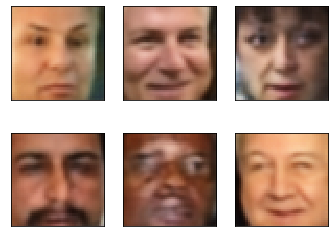

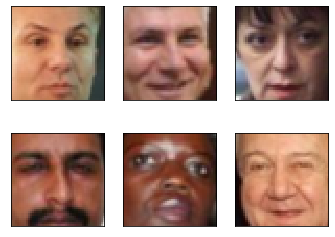

epoch: 50 out of 50
train_loss: 0.0010638454301282764	 val_loss:0.001519981747372547


In [ ]:
best_param, train_losses, val_losses = train(val_loader, train_loader, 50)

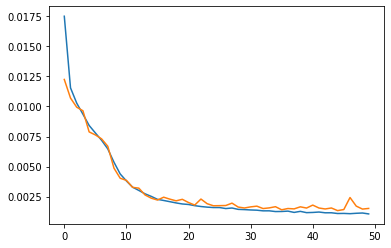

In [ ]:
plt.plot(train_losses, label = 'train')
plt.plot(val_losses, label = 'val')

In [ ]:
torch.save(best_param.state_dict(), '/content/Autoencoder_50.pth')

In [20]:
autoencoder.load_state_dict(torch.load('/content/Autoencoder_50.pth'))

<All keys matched successfully>

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [21]:
with torch.no_grad():
  real = next(iter(val_loader))
  output1 = autoencoder.encoder_(real.to(DEVICE))
  output = autoencoder.decoder_(output1.to(DEVICE))

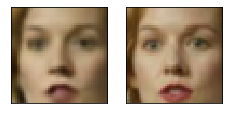

In [22]:
plot_gallery([output[3].cpu().numpy().transpose(1, 2, 0), real[3].cpu().numpy().transpose(1, 2, 0)], IMAGE_H, IMAGE_W, 1, 2)

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что ридется рандом подогнать.

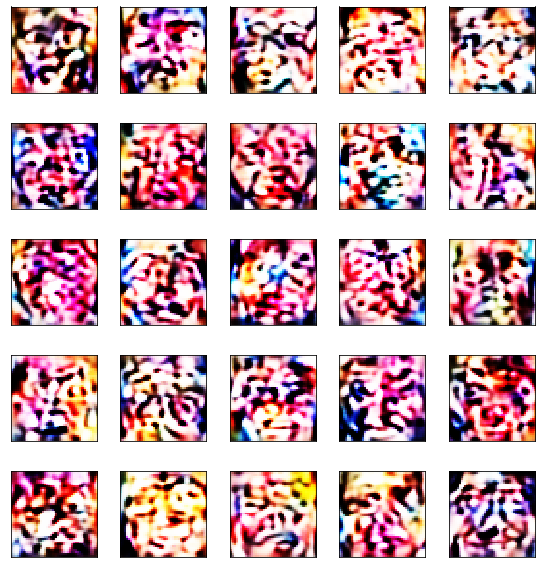

In [43]:
# сгенерируем 25 рандомных векторов размера latent_space
z = torch.randn(25, 250)
with torch.no_grad():
  autoencoder.eval()
  output = autoencoder.decoder_(z.to(DEVICE))
  plot_gallery(output.cpu().numpy().transpose(0, 2, 3, 1), IMAGE_H, IMAGE_W, n_row=5, n_col=5)

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [24]:
attrs

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.56835,-1.88904,1.7372,-0.929729,-1.4718,-0.19558,-0.835609,-0.351468,-1.01253,-0.719593,-0.632401,0.464839,-0.973528,1.56519,-1.2967,-1.54272,-0.684671,-0.86499,0.766886,-0.218952,-1.65567,-0.787044,-0.599665,0.458519,0.18976,0.851555,-0.38572,-0.497719,-0.161149,-0.257514,-0.0888388,0.455469,-0.839211,-0.0229481,-0.922568,-0.114539,1.46122,1.75848,0.0688935,1.26786,-1.12024,0.917617,-1.30796,-1.50041,1.02922,0.832363,-0.498657,0.251365,-0.705281,-0.515715,0.374239,-0.168675,-0.614143,3.0977,1.52386,0.779278,-0.0714539,-1.24648,-0.769283,-0.725597,-1.82061,-2.07298,-0.960759,0.361738,1.16612,-1.16492,-1.13999,-2.37175,-1.29993,-0.414682,-1.1449,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.28218,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,-0.736883,0.294554,-1.27765,0.954771,-0.990992,-1.16736,-0.835146,0.798544,-0.971679,0.342826,-1.32256,0.962937,-1.19936,-0.157307,0.443224,-0.00288156,-0.0211584,-0.226563,-0.0810386,-0.827202,-0.106624,1.22759,-0.812223,-1.24126,0.0962725,-0.404544,0.325919,0.474452,1.13536,0.0587247,0.611176,-1.17251,0.428512,-0.874235,-1.19156,0.192359,-0.204166,0.342347,0.239512,-1.47469,0.236057,-0.565208,-0.712542,2.99708,-0.273306,-0.187722,-0.604608,-1.3217,-0.938559,0.494294,-0.659043,-1.14375,-0.775722,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.00624408,-0.0304057,-0.480128,0.66676,-0.496559
2,0.997749,-1.36419,-0.157377,-0.756447,-1.89183,-0.871526,-0.862893,0.0314447,-1.34152,-0.0900375,-1.20073,-0.33246,-0.537006,1.29836,-1.49847,-1.28582,1.14174,0.172817,0.106412,-0.788843,0.349295,-1.64372,0.454287,1.18946,-0.688414,-0.590574,-0.266673,0.467224,0.567348,-1.7191,0.124667,1.60274,-0.659399,-1.75376,1.20447,0.0221884,-1.13544,1.70286,-0.422144,0.587859,0.414363,0.344447,-1.26045,-0.577746,0.405567,-1.91655,0.92126,0.247437,-0.428451,-0.772273,0.370673,-0.509596,-0.768482,1.7069,0.126524,-0.497001,-0.393042,-0.178307,-1.18023,-0.596914,-1.80538,-0.951643,-0.838087,1.54974,1.88475,-0.999765,-1.35986,-1.91211,-1.09563,0.915126,-0.572332,0.144262,-0.841231
3,1.12272,-1.9978,1.91614,-2.51421,-2.58007,-1.40424,0.0575511,0.000195882,-1.27351,-1.43146,-0.0705188,-0.339239,-2.00415,0.665695,-0.77594,-1.47163,-1.17908,0.563327,-0.664429,-1.40793,0.435594,-0.589988,-1.6035,1.17074,0.760103,0.211498,-0.51618,-1.33115,0.20284,0.149645,-0.0464296,0.640885,-0.107616,-0.831271,-0.827005,-0.588725,0.429255,1.58766,0.499086,-0.0568692,-0.866643,-0.959689,0.35073,-1.33535,-0.42789,0.826817,-0.256779,0.149751,-1.20153,-1.08392,0.255363,-0.650423,-0.506293,1.10159,0.640783,1.57503,-0.484397,-1.55968,-1.43712,0.379363,-0.648233,-2.25735,-1.07561,0.567822,-0.176089,1.10812,-1.60094,-3.26461,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.07821,-2.0081,1.67621,-2.27806,-2.65185,-1.34841,0.649089,0.0176564,-1.88911,-1.85721,-0.568057,0.840375,-1.98127,1.66671,-0.910723,-1.99351,-0.871335,0.507786,-0.488947,-0.88649,-0.990132,-0.750813,-0.378479,0.583086,-1.4796,0.250185,-0.381123,-0.611991,-0.143091,-1.07276,0.432094,1.08919,-0.470929,-1.17712,-0.111313,-0.154603,-1.03151,2.39246,-0.191576,1.2279,-1.3818,-1.52885,0.907964,-1.32429,-0

In [26]:
def plot_new_face(image):
  id_new_positive_woman = attrs[(attrs['Male'] < 0)&(attrs['Smiling'] > 0)].sort_values(by='Smiling',ascending = False).head(15).index.values
  id_new_positive_man = attrs[(attrs['Male'] > 0)&(attrs['Smiling'] > 0)].sort_values(by='Smiling',ascending = False).head(15).index.values
  id_new_positive = np.concatenate(( id_new_positive_woman, id_new_positive_man), 0)
  id_negative_woman = attrs[(attrs['Male'] < 0)&(attrs['Smiling'] < 0)].sort_values(by='Smiling',ascending = True).head(15).index.values
  id_negative_man =  attrs[(attrs['Male'] > 0)&(attrs['Smiling'] < 0)].sort_values(by='Smiling',ascending = True).head(15).index.values
  id_new_negative = np.concatenate((id_negative_woman, id_negative_man), 0)

  autoencoder.eval()
  human = torch.FloatTensor(image.transpose(0, 2, 1)/255.).unsqueeze_(0)

  with torch.no_grad():
    positive_latent = autoencoder.encoder_(torch.FloatTensor(next(iter(data[id_new_positive]))).unsqueeze_(0).to(DEVICE))
    negative_latent = autoencoder.encoder_(torch.FloatTensor(next(iter(data[id_new_negative]))).unsqueeze_(0).to(DEVICE))
    latent_mean = (torch.mean(positive_latent, axis=0)-torch.mean(negative_latent, axis=0)).unsqueeze_(0)
    human_latent = autoencoder.encoder_(human.to(DEVICE))
    new_human = autoencoder.decoder_(latent_mean + human_latent)
  plot_gallery([new_human.cpu().numpy().transpose(0, 2, 3, 1), human.cpu().numpy().transpose(0, 3, 2, 1)], IMAGE_H, IMAGE_W, 1, 2)

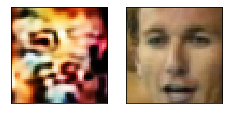

In [42]:
plot_new_face(data[6])

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии)

# Conditional Autoencoder (3 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет

Как вы уже догадались, здесь мы будем использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/)

Если он вам очень не нравится, можете загуглить любой другой, в котором будет четкое разделение картинок по классам.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = datasets.MNIST(root='./data', train=True, 
                                      download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64,
                                          shuffle=True)

valset = datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
valloader = DataLoader(valset, batch_size=64,
                        shuffle=False)
classes = tuple(str(i) for i in range(10))

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!





/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [ ]:
next(iter(trainloader))[0][10]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0235, 0.0078,
          0.4118, 0.9922, 0.6549, 0.3725, 0.0000, 0.0000,

In [ ]:
def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
      nn.init.xavier_uniform_(m.weight)

class Autoencoder_MNIST(nn.Module):
    def __init__(self, latent=250):
        super().__init__()
        self.latent = latent
        #на вход (28, 28)+ one_hot
        self.fc_encode = nn.Sequential(nn.Linear(28*28, 28*28),
                                 nn.LeakyReLU(0.2))#попробовать поменять на sigmoid
        #выход (28,28)
        self.conv1_down = nn.Sequential(nn.Conv2d(1, 20, 3, padding=1),
                                        nn.BatchNorm2d(20),
                                        nn.LeakyReLU(0.2),
        )
        self.conv2_down = nn.Sequential(nn.Conv2d(20, 40, 3),
                                        nn.BatchNorm2d(40),
                                        nn.LeakyReLU(0.2),
                                        nn.MaxPool2d(2)
        ) 
        self.conv3_down = nn.Sequential(nn.Conv2d(40, 60, 3),
                                        nn.BatchNorm2d(60),
                                        nn.LeakyReLU(0.2),
        )
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(60*5*5, latent)
        #выход 250
        self.fc2 = nn.Sequential(nn.Linear(latent, 60*5*5),
                                 nn.LeakyReLU(0.2)
        )
        self.conv3_up = nn.Sequential(nn.ConvTranspose2d(60, 40, 3, stride=2),
                                      nn.BatchNorm2d(40),# формула size+(size-1) + (pad)*2 - (kernel-1), где pad = 0, если padding=2, 1, если 1, 2, если 0 и еще padding зависит от kernel (pad = 2 для 3, pad=3 для 4)
                                      nn.LeakyReLU(0.2)

        )
        self.conv2_up = nn.Sequential(nn.ConvTranspose2d(40, 20, 3, stride = 1),
                                      nn.BatchNorm2d(20),
                                      nn.LeakyReLU(0.2)
        )
        self.conv1_up = nn.Sequential(nn.ConvTranspose2d(20, 10, 3, stride=1),
                                      nn.BatchNorm2d(10),
                                      nn.LeakyReLU(0.2),
                                      nn.ConvTranspose2d(10, 5, 3, stride=2, padding = 1),
                                      nn.BatchNorm2d(5),
                                      nn.LeakyReLU(0.2),
                                      nn.Conv2d(5, 1, 4, padding=1)
        )


    def encoder_(self, x, y):
        x = self.fc_encode(x + y).view(-1, 1, 28, 28) # попробовать конкатенировать, а не прибавлять
        self.conv1 = self.conv1_down(x)
        self.conv2 = self.conv2_down(self.conv1)
        self.conv3 = self.conv3_down(self.conv2)
        latent_code = torch.tanh(self.fc1(self.pool(self.conv3).view(x.size(0), -1)))
        return latent_code


    def decoder_(self, z, y):
        z = self.fc2(z + y).view(-1, 60, 5, 5) # попробовать конкатенировать, а не прибавлять
        z = self.conv3_up(z)
        z = self.conv2_up(z)
        z = self.conv1_up(z)
        reconstruct = torch.sigmoid(z) 
        return reconstruct   

    def forward(self, x, y1, y2):
        encoder = self.encoder_(x, y1)
        decoder = self.decoder_(encoder, y2)
        return decoder, encoder

In [ ]:
Latent = 10
DEVICE = torch.device('cuda')
autoencoder_mnist = Autoencoder_MNIST(Latent).to(DEVICE)
autoencoder_mnist.apply(init_weights)
optimizer = optim.Adam(autoencoder_mnist.parameters())
criterion = nn.MSELoss()
#summary(autoencoder, (30, 28*28))

In [ ]:

def OneHot(batch, data, dim):
  massive = np.zeros((batch, dim))
  data = pd.Series(np.array(data.cpu()), index = np.arange(len(data)))
  massive[np.array(data.index), np.array(data)] = 1
  return torch.IntTensor(massive)

In [ ]:
def train(val, train, epochs):
  train_losses = []
  val_losses = []
  best_model_wts = autoencoder_mnist.state_dict()
  best_loss = np.inf
  for epoch in range(epochs):
    loss_train_running = 0
    total_train_data = 0
    loss_val_running = 0
    total_val_data = 0
    autoencoder_mnist.train()
    for X, y in trainloader:
      X = X.to(DEVICE)
      optimizer.zero_grad()
      output = autoencoder_mnist(X.view(-1, 28*28).to(DEVICE), OneHot(len(X), y, 28*28).to(DEVICE), OneHot(len(X), y, Latent).to(DEVICE))[0]
      loss = criterion(output, X)
      loss.backward()
      optimizer.step()
      loss_train_running += loss.item()*X.size(0)
      total_train_data += X.size(0)
    train_losses.append(loss_train_running/total_train_data)
    autoencoder_mnist.eval()
    for X_, y_ in valloader:
      X_ = X_.to(DEVICE)
      with torch.no_grad():
        output_ = autoencoder_mnist(X_.view(-1, 28*28).to(DEVICE), OneHot(len(X_), y_, 28*28).to(DEVICE), OneHot(len(X_), y_, Latent).to(DEVICE))[0]
        loss_ = criterion(output_, X_)
      loss_val_running += loss_.item()*X_.size(0)
      total_val_data += X_.size(0)
    val_losses.append(loss_val_running/total_val_data)
    if val_losses[-1]< best_loss:
      best_loss = val_losses[-1]
      best_model_wts = autoencoder_mnist.state_dict()
    clear_output(True)
    plt.imshow(output_[-1].squeeze_(0).cpu().numpy(), cmap='gray')
    plt.show()
    plt.imshow(X_[-1].squeeze_(0).cpu().numpy(), cmap='gray')
    plt.show()
    print("epoch: {} out of {}".format(epoch+1, epochs))
    print("train_loss: {}\t val_loss:{}".format(train_losses[-1], val_losses[-1]))
  autoencoder_mnist.load_state_dict(best_model_wts)
  return autoencoder_mnist, train_losses, val_losses

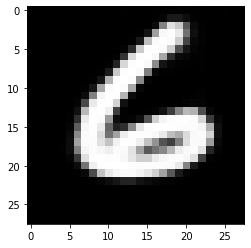

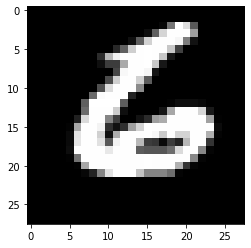

epoch: 30 out of 30
train_loss: 0.009392704131205876	 val_loss:0.010407747726142407


In [ ]:
best, train_losses, val_losses = train(valloader, trainloader, 30)

In [ ]:
torch.save(best.state_dict(), '/content/Autoencoder_50_mnist.pth')
autoencoder_mnist.load_state_dict(torch.load('/content/Autoencoder_50_mnist.pth'))

<All keys matched successfully>

## Sampling


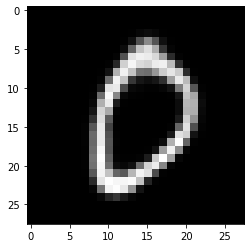

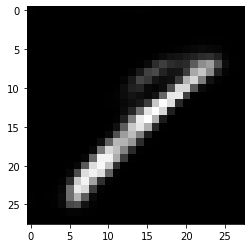

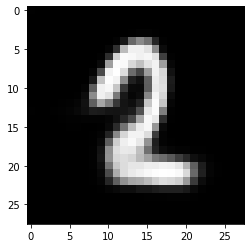

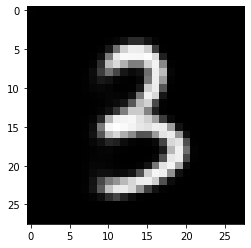

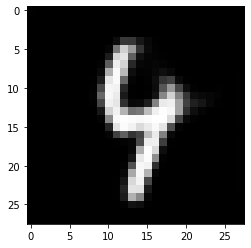

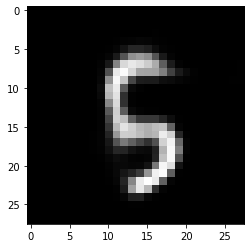

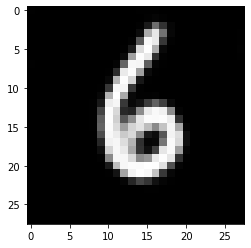

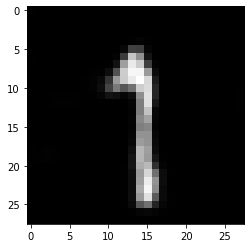

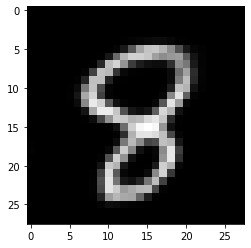

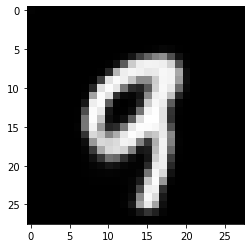

In [ ]:
def sampling(number):
  z = torch.randn(1, Latent)*0.1
  condition = OneHot(1, torch.IntTensor([number]), Latent)
  with torch.no_grad():
    autoencoder_mnist.eval()
    output = autoencoder_mnist.decoder_(z.to(DEVICE), condition.to(DEVICE))
    plt.imshow(output.squeeze_(0)[0].cpu().numpy(), cmap='gray')
    plt.show()
for i in range(10):
  sampling(i)

Splendid! Вы великолепны!

Теперь давайте сделаем следующее: посмотрим на то, как выглядит латентное пространство векторов, соответствующих нашим картинкам. 
Для этого вам нужно:
1.  прогнать картинки из датасета через encoder, получить латентные векторы
2. Прогнать векторы через TSNE, получить их двумерную проекцию
3. Изобразить полученные после TSNE двумерные векторы на плоскости с помощью plt.scatter, покрасив точки в цвета в зависимости от класса картинки, которой она соответствует. (как красить точки, см. в документации к plt.scatter). 
4. Подумать, что вы видите и записать свои мысли

In [ ]:
!wget https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda100.tar.bz2
!tar xvjf tsnecuda-2.1.0-cuda100.tar.bz2
!cp -r site-packages/* /usr/local/lib/python3.6/dist-packages/

--2020-06-24 11:32:51--  https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda100.tar.bz2
Resolving anaconda.org (anaconda.org)... 104.17.93.24, 104.17.92.24, 2606:4700::6811:5d18, ...
Connecting to anaconda.org (anaconda.org)|104.17.93.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-tar]
Saving to: ‘tsnecuda-2.1.0-cuda100.tar.bz2’

tsnecuda-2.1.0-cuda     [   <=>              ]  35.75M  83.7MB/s    in 0.4s    

2020-06-24 11:32:52 (83.7 MB/s) - ‘tsnecuda-2.1.0-cuda100.tar.bz2’ saved [37484309]

info/hash_input.json
info/index.json
info/files
info/git
info/about.json
info/recipe/docker/Dockerfile
info/recipe/docs/results/speedup.png
info/recipe/docs/results/multi-threaded.png
info/recipe/docs/cifar_speedup.png
info/recipe/docs/results/single-threaded.png
info/recipe/docs/mnist_speedup.png
info/recipe/docs/simulated_speedup.png
info/recipe/build/.gitkeep
info/recipe/conda_build_config.yaml
info/recipe/m

In [ ]:
!echo $LD_LIBRARY_PATH 
# this is probably /usr/lib64-nvidia

!ln -s /content/lib/libfaiss.so $LD_LIBRARY_PATH/libfaiss.so

/usr/lib64-nvidia


In [ ]:
autoencoder_mnist.eval()
output = np.array((64*10)*[]).reshape(-1, 10)
labels = np.array((64*[]))
with torch.no_grad():
  for X, y in trainloader:
    output = np.concatenate((autoencoder_mnist.encoder_(X.view(-1, 28*28).to(DEVICE), OneHot(len(X), y, 28*28).to(DEVICE)).cpu().numpy(), output), axis = 0)
    labels = np.concatenate((y.cpu().numpy(), labels))

In [ ]:
import tsnecuda
tsnecuda.test()

In [ ]:
from tsnecuda import TSNE as TSNE_CUDA
tsne_cuda = TSNE_CUDA(
    n_components=2, 
    perplexity=30.0, 
    early_exaggeration=12.0, 
    learning_rate=200.0, 
    n_iter=1000, 
    n_iter_without_progress=300, 
    min_grad_norm=1e-07, 
    metric='euclidean', 
    init='random', 
    verbose=0,
    random_seed=None, # different parameter name
    theta=0.5 # different parameter name
)

In [ ]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
scaled = scale.fit_transform(output[:4000])
result = tsne_cuda.fit_transform(scaled)

In [ ]:
data = pd.DataFrame(result, index = labels[:4000])
data.head()

,0,1
6.0,23.579527,-6.716123
2.0,15.313511,-0.040137
0.0,11.539943,2.372794
9.0,7.832614,-11.757270
9.0,-0.543250,-13.866114


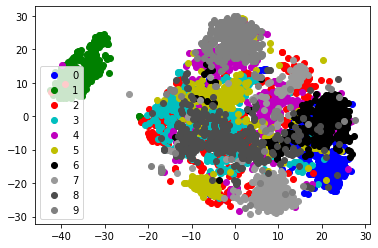

In [ ]:
fig, ax = plt.subplots()

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '0.6', '0.3', '0.5']
for i in range(10):
  ax.scatter(data.loc[i][0].values, data.loc[i][1].values, c=colors[i], label = i)
plt.legend()

<тут ваши мысли по поводу того, что вы видите на рисунке>

# BONUS 1. (2 балла) 
### Variational Autoencoder

Если вы (надеюсь) осознали, в каком месте у conditional AE выше могли бы быть проблемы, то -- тадам!!

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent = 10, dim = 28):
        super().__init__()
        self.latent = latent
        self.hid = int((int((dim-2)/2)-2)/2)

        self.conv1_down = nn.Sequential(nn.Conv2d(1, 10, 3, padding=1),
                                        nn.BatchNorm2d(10, 1e-3),
                                        nn.ReLU(),
        )
        self.conv2_down = nn.Sequential(nn.Conv2d(10, 20, 3),
                                        nn.BatchNorm2d(20, 1e-3),
                                        nn.ReLU(),
                                        nn.MaxPool2d(2)
        ) 
        self.conv3_down = nn.Sequential(nn.Conv2d(20, 40, 3),
                                        nn.BatchNorm2d(40, 1e-3),
                                        nn.ReLU(),
        )
        self.pool = nn.MaxPool2d(2)
        self.fc_mu = nn.Linear(40*self.hid*self.hid, self.latent)
        self.fc_logsigma = nn.Linear(40*self.hid*self.hid, self.latent)

        #выход 250
        self.fc2 = nn.Sequential(nn.Linear(self.latent, 40*self.hid*self.hid)
        )
        self.conv3_up = nn.Sequential(nn.ConvTranspose2d(40, 20, 3, stride=2),
                                      nn.BatchNorm2d(20, 1e-3),# формула size+(size-1) + (pad)*2 - (kernel-1), где pad = 0, если padding=2, 1, если 1, 2, если 0 и еще padding зависит от kernel (pad = 2 для 3, pad=3 для 4)
                                      nn.ReLU()

        )
        self.conv2_up = nn.Sequential(nn.ConvTranspose2d(20, 20, 3, stride = 1),
                                      nn.BatchNorm2d(20, 1e-3),
                                      nn.ReLU()
        )
        self.conv1_up = nn.Sequential(nn.ConvTranspose2d(20, 10, 3, stride=1),
                                      nn.BatchNorm2d(10, 1e-3),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(10, 5, 3, stride=2, padding = 1),
                                      nn.BatchNorm2d(5, 1e-3),
                                      nn.ReLU(),
                                      nn.Conv2d(5, 1, 4, padding=1)
        )


    def encode(self, x):
        self.conv1 = self.conv1_down(x)
        self.conv2 = self.conv2_down(self.conv1)
        self.conv3 = self.conv3_down(self.conv2)
        mu = self.fc_mu(self.pool(self.conv3).view(x.size(0), -1))
        logsigma = self.fc_logsigma(self.pool(self.conv3).view(x.size(0), -1))
        return mu, logsigma
    

    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        std = torch.exp(logsigma*0.5)
        esp = torch.randn(*mu.size()).to(DEVICE)
        return mu + std * esp
    

    def decode(self, z):
        z = self.fc2(z).view(-1, 40, self.hid, self.hid)
        z = self.conv3_up(z)
        z = self.conv2_up(z)
        z = self.conv1_up(z)
        reconstruct = torch.sigmoid(z) 
        return reconstruct
        

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    return -(0.5) * torch.sum(1 + logsigma - mu**2 - torch.exp(logsigma))

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    return F.binary_cross_entropy(reconstruction, x, reduction='sum')

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [ ]:
DEVICE = torch.device('cuda')

autoencoder_vae = VAE(10).to(DEVICE)
#autoencoder_vae.apply(init_weights)

optimizer = optim.Adam(autoencoder_vae.parameters(), lr = 1e-4)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.8)

summary(autoencoder_vae, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
       BatchNorm2d-2           [-1, 10, 28, 28]              20
              ReLU-3           [-1, 10, 28, 28]               0
            Conv2d-4           [-1, 20, 26, 26]           1,820
       BatchNorm2d-5           [-1, 20, 26, 26]              40
              ReLU-6           [-1, 20, 26, 26]               0
         MaxPool2d-7           [-1, 20, 13, 13]               0
            Conv2d-8           [-1, 40, 11, 11]           7,240
       BatchNorm2d-9           [-1, 40, 11, 11]              80
             ReLU-10           [-1, 40, 11, 11]               0
        MaxPool2d-11             [-1, 40, 5, 5]               0
           Linear-12                   [-1, 10]          10,010
        MaxPool2d-13             [-1, 40, 5, 5]               0
           Linear-14                   

In [ ]:
torch.autograd.set_detect_anomaly(True)
def train(val, train, epochs):
  train_losses = []
  val_losses = []
  best_model_wts = autoencoder_vae.state_dict()
  best_loss = np.inf
  for epoch in range(epochs):
    loss_train_running = 0
    total_train_data = 0
    loss_val_running = 0
    total_val_data = 0
    autoencoder_vae.train()
    for X, _ in trainloader:
      X = X.to(DEVICE)
      optimizer.zero_grad()
      mu, logsigma, output = autoencoder_vae(X)
      loss = loss_vae(X,mu, logsigma, output)
      loss.backward()
      optimizer.step()
      loss_train_running += loss.item()*X.size(0)
      total_train_data += X.size(0)
    train_losses.append(loss_train_running/total_train_data)
    autoencoder_vae.eval()
    for X_, _ in valloader:
      X_ = X_.to(DEVICE)
      with torch.no_grad():
        mu_, logsigma_, output_ = autoencoder_vae(X_)
        loss_ = loss_vae(X_, mu_, logsigma_, output_)
      loss_val_running += loss_.item()*X_.size(0)
      total_val_data += X_.size(0)
    print(torch.mean(mu_), torch.mean(logsigma_))
    val_losses.append(loss_val_running/total_val_data)
    if val_losses[-1]< best_loss:
      best_loss = val_losses[-1]
      best_model_wts = autoencoder_vae.state_dict()
    #scheduler.step()
    clear_output(True)
    plt.imshow(output_[-1].squeeze_(0).cpu().numpy(), cmap='gray')
    plt.show()
    plt.imshow(X_[-1].squeeze_(0).cpu().numpy(), cmap='gray')
    plt.show()
    print("epoch: {} out of {}".format(epoch+1, epochs))
    print("train_loss: {}\t val_loss:{}".format(train_losses[-1], val_losses[-1]))
  autoencoder_vae.load_state_dict(best_model_wts)
  return autoencoder_vae, train_losses, val_losses

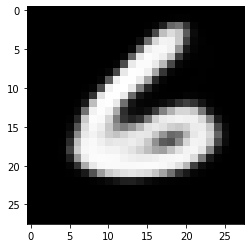

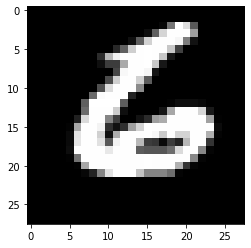

epoch: 50 out of 50
train_loss: 6705.22103203125	 val_loss:6685.955715039063


In [ ]:
best_vae, train_losses, val_losses = train(valloader, trainloader, 50)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
torch.save(best_vae.state_dict(), '/content/Autoencoder_vae_mnist.pth')
autoencoder_vae.load_state_dict(torch.load('/content/Autoencoder_vae_mnist.pth'))

<All keys matched successfully>

And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие лица получатся:

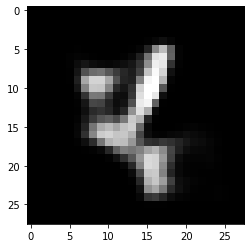

In [ ]:
# вспомните про замечание из этого же ункта обычного AE про распределение латентных переменных
def sample():
  z = torch.randn(1, 10)
  autoencoder_vae.eval()
  with torch.no_grad():
    output = autoencoder_vae.decode(z.to(DEVICE))
  plt.imshow(output.cpu()[0][0].numpy(), cmap='gray')
  plt.show()
sample()

## Congrats v2.0!

Как вы уже догадались, здесь тоже можно попробовать пририсовывать разные атрибуты людям. Можно, например, так же пририсовать улыбки и сравнить с тем, как это получалось у обычного автоэнкодера

In [ ]:
<как вы уже догадались, тут Ваш код>

# BONUS 2. (2 балла)

А теперь пришло время сделать 
## Conditional Variational AE

In [ ]:
#проверить код
class CVAE(nn.Module):
    def __init__(self, latent = 10, dim = 28):
        super().__init__()
        self.latent = latent
        self.dim = dim
        self.hid = int((int((dim-2)/2)-2)/2)

        self.fc_encode = nn.Sequential(nn.Linear(self.dim**2+10, self.dim**2),
                                 nn.LeakyReLU(0.2)
        )
        self.conv1_down = nn.Sequential(nn.Conv2d(1, 10, 3, padding=1),
                                        nn.BatchNorm2d(10, 1e-3),
                                        nn.LeakyReLU(0.2),
        )
        self.conv2_down = nn.Sequential(nn.Conv2d(10, 20, 3),
                                        nn.BatchNorm2d(20, 1e-3),
                                        nn.LeakyReLU(0.2),
                                        nn.MaxPool2d(2)
        ) 
        self.conv3_down = nn.Sequential(nn.Conv2d(20, 40, 3),
                                        nn.BatchNorm2d(40, 1e-3),
                                        nn.LeakyReLU(0.2),
        )
        self.pool = nn.MaxPool2d(2)
        self.fc_mu = nn.Linear(40*self.hid*self.hid, self.latent)
        self.fc_logsigma = nn.Linear(40*self.hid*self.hid, self.latent)

        #выход 250
        self.fc2 = nn.Sequential(nn.Linear(self.latent + 10 , 40*self.hid*self.hid)
        )
        self.conv3_up = nn.Sequential(nn.ConvTranspose2d(40, 20, 3, stride=2),
                                      nn.BatchNorm2d(20, 1e-3),# формула size+(size-1) + (pad)*2 - (kernel-1), где pad = 0, если padding=2, 1, если 1, 2, если 0 и еще padding зависит от kernel (pad = 2 для 3, pad=3 для 4)
                                      nn.LeakyReLU(0.2)

        )
        self.conv2_up = nn.Sequential(nn.ConvTranspose2d(20, 20, 3, stride = 1),
                                      nn.BatchNorm2d(20, 1e-3),
                                      nn.LeakyReLU(0.2)
        )
        self.conv1_up = nn.Sequential(nn.ConvTranspose2d(20, 10, 3, stride=1),
                                      nn.BatchNorm2d(10, 1e-3),
                                      nn.LeakyReLU(0.2),
                                      nn.ConvTranspose2d(10, 5, 3, stride=2, padding = 1),
                                      nn.BatchNorm2d(5, 1e-3),
                                      nn.LeakyReLU(0.2),
                                      nn.Conv2d(5, 1, 4, padding=1)
        )


    def encode(self, x):
        x = self.fc_encode(x).view(-1, 1, self.dim, self.dim)
        self.conv1 = self.conv1_down(x)
        self.conv2 = self.conv2_down(self.conv1)
        self.conv3 = self.conv3_down(self.conv2)
        mu = self.fc_mu(self.pool(self.conv3).view(x.size(0), -1))
        logsigma = self.fc_logsigma(self.pool(self.conv3).view(x.size(0), -1))
        return mu, logsigma
    

    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        std = torch.exp(logsigma*0.5)
        esp = torch.randn(*mu.size()).to(DEVICE)
        return mu + std * esp
    

    def decode(self, z, y):
        z = torch.cat((z.view(-1, self.latent), OneHot(z.size(0), y, 10).to(DEVICE)), dim = 1)
        z = self.fc2(z).view(-1, 40, self.hid, self.hid)
        z = self.conv3_up(z)
        z = self.conv2_up(z)
        z = self.conv1_up(z)
        reconstruct = torch.sigmoid(z) 
        return reconstruct
        

    def forward(self, x, y):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, y)
        return mu, logsigma, reconstruction

In [ ]:
DEVICE = torch.device('cuda')
Latent = 10

autoencoder_cvae = CVAE(Latent).to(DEVICE)
#autoencoder_cvae.apply(init_weights)

optimizer = optim.Adam(autoencoder_cvae.parameters(), lr = 1e-4)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)

#summary(autoencoder_cvae, (64, 28*28+10))

In [ ]:
def OneHot(batch, data, dim):
  massive = np.zeros((batch, dim))
  data = pd.Series(np.array(data.cpu()), index = np.arange(len(data)))
  massive[np.array(data.index), np.array(data)] = 1
  return torch.FloatTensor(massive)

In [ ]:
torch.autograd.set_detect_anomaly(True)
#проверить код
def train(val, train, epochs):
  train_losses = []
  val_losses = []
  best_model_wts = autoencoder_cvae.state_dict()
  best_loss = np.inf
  for epoch in range(epochs):
    loss_train_running = 0
    total_train_data = 0
    loss_val_running = 0
    total_val_data = 0
    autoencoder_cvae.train()
    for X, y in trainloader:
      X = X.to(DEVICE)
      optimizer.zero_grad()
      input = torch.cat((X.view(-1, 28*28), OneHot(X.size(0), y, 10).to(DEVICE)), dim = 1)
      mu, logsigma, output = autoencoder_cvae(input.to(DEVICE), y)
      loss = loss_vae(X,mu, logsigma, output)
      loss.backward()
      optimizer.step()
      loss_train_running += loss.item()*X.size(0)
      total_train_data += X.size(0)
    train_losses.append(loss_train_running/total_train_data)
    autoencoder_cvae.eval()
    for X_, y_ in valloader:
      X_ = X_.to(DEVICE)
      with torch.no_grad():
        input_ = torch.cat((X_.view(-1, 28*28), OneHot(X_.size(0), y_, 10).to(DEVICE)), dim = 1)
        mu_, logsigma_, output_ = autoencoder_cvae(input_.to(DEVICE), y_)
        loss_ = loss_vae(X_, mu_, logsigma_, output_)
      loss_val_running += loss_.item()*X_.size(0)
      total_val_data += X_.size(0)
    print(torch.mean(mu_), torch.mean(logsigma_))
    val_losses.append(loss_val_running/total_val_data)
    if val_losses[-1]< best_loss:
      best_loss = val_losses[-1]
      best_model_wts = autoencoder_cvae.state_dict()
    #scheduler.step()
    clear_output(True)
    plt.imshow(output_[-1].squeeze_(0).cpu().numpy(), cmap='gray')
    plt.show()
    plt.imshow(X_[-1].squeeze_(0).cpu().numpy(), cmap='gray')
    plt.show()
    print("epoch: {} out of {}".format(epoch+1, epochs))
    print("train_loss: {}\t val_loss:{}".format(train_losses[-1], val_losses[-1]))
  autoencoder_cvae.load_state_dict(best_model_wts)
  return autoencoder_cvae, train_losses, val_losses

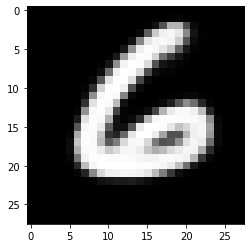

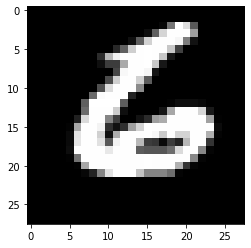

epoch: 100 out of 100
train_loss: 5994.873741927084	 val_loss:6088.825118554688


In [ ]:
best_cvae, train_losses, val_losses = train(valloader, trainloader, 100)

In [ ]:
torch.save(best_cvae.state_dict(), '/content/Autoencoder_cvae.pth')
autoencoder_cvae.load_state_dict(torch.load('/content/Autoencoder_cvae.pth'))

<All keys matched successfully>

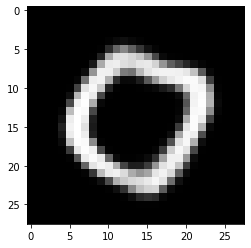

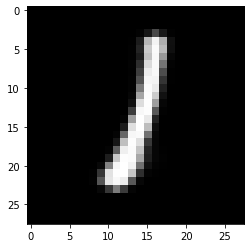

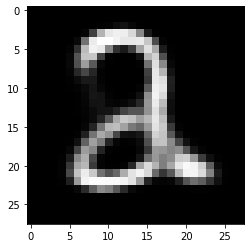

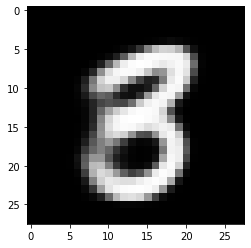

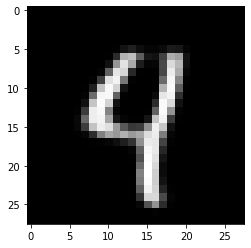

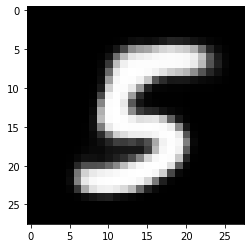

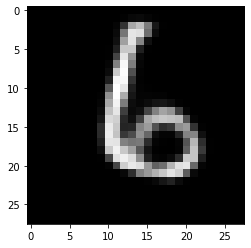

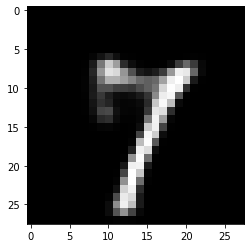

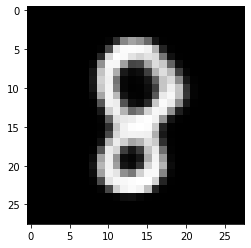

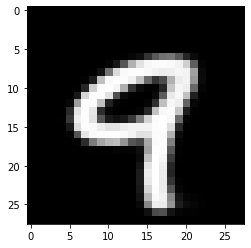

In [ ]:
def sampling(number):
  z = torch.randn(1, Latent)
  #condition = OneHot(1, torch.IntTensor([number]), Latent) 
  with torch.no_grad():
    autoencoder_cvae.eval()
    output = autoencoder_cvae.decode(z.to(DEVICE), torch.IntTensor([number]))
    plt.imshow(output.squeeze_(0)[0].cpu().numpy(), cmap='gray')
    plt.show()
for i in range(10):
  sampling(i)

... и так же посмотреть на латентное пространство векторов VAE, как мы делали это с обычным variational AE, понять, чем же оно отличается и сделать выводы:

In [ ]:
<тут код>

<тут выводы>

# BONUS 3. (2 балла)

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонксное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
DEVICE = torch.device('cuda')
autoencoder = Autoencoder_2().to(DEVICE)
autoencoder.apply(init_weights)
optimizer = optim.Adam(autoencoder.parameters())
criterion = nn.MSELoss()
summary(autoencoder, (3,45, 45))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 45, 45]             560
       BatchNorm2d-2           [-1, 20, 45, 45]              40
         LeakyReLU-3           [-1, 20, 45, 45]               0
            Conv2d-4           [-1, 40, 45, 45]           7,240
       BatchNorm2d-5           [-1, 40, 45, 45]              80
         LeakyReLU-6           [-1, 40, 45, 45]               0
            Conv2d-7           [-1, 80, 43, 43]          28,880
       BatchNorm2d-8           [-1, 80, 43, 43]             160
         LeakyReLU-9           [-1, 80, 43, 43]               0
           Conv2d-10          [-1, 100, 43, 43]          72,100
      BatchNorm2d-11          [-1, 100, 43, 43]             200
        LeakyReLU-12          [-1, 100, 43, 43]               0
        MaxPool2d-13          [-1, 100, 21, 21]               0
           Conv2d-14          [-1, 150,

In [ ]:
def train(val, train, epochs, noise_factor = 0.1):
  train_losses = []
  val_losses = []
  best_model_wts = autoencoder.state_dict()
  best_loss = np.inf
  for epoch in range(epochs):
    loss_train_running = 0
    total_train_data = 0
    loss_val_running = 0
    total_val_data = 0
    autoencoder.train()
    for X in train_loader:
      X = X.to(DEVICE)
      X_noisy = X + noise_factor * torch.randn(*X.size()).to(DEVICE)
      optimizer.zero_grad()
      output = autoencoder(X_noisy)[0]
      loss = criterion(output, X)
      loss.backward()
      optimizer.step()
      loss_train_running += loss.item()*X.size(0)
      total_train_data += X.size(0)
    train_losses.append(loss_train_running/total_train_data)
    autoencoder.eval()
    for X_ in val_loader:
      X_ = X_.to(DEVICE)
      X_noisy_ = X_ + noise_factor * torch.randn(*X_.size()).to(DEVICE)
      with torch.no_grad():
        output_ = autoencoder(X_noisy_)[0]
        loss_ = criterion(output_, X_)
      loss_val_running += loss_.item()*X_.size(0)
      total_val_data += X_.size(0)
    val_losses.append(loss_val_running/total_val_data)
    if val_losses[-1]< best_loss:
      best_loss = val_losses[-1]
      best_model_wts = autoencoder.state_dict()
    clear_output(True)
    plot_gallery(output_[:10].cpu().numpy().transpose(0, 2, 3, 1), IMAGE_H, IMAGE_W, n_row=2, n_col=3)
    plot_gallery(np.clip(X_noisy_[:10].cpu().numpy().transpose(0, 2, 3, 1), 0, 1), IMAGE_H, IMAGE_W, n_row=2, n_col=3)
    plt.show()
    print("epoch: {} out of {}".format(epoch+1, epochs))
    print("train_loss: {}\t val_loss:{}".format(train_losses[-1], val_losses[-1]))
  autoencoder.load_state_dict(best_model_wts)
  return autoencoder, train_losses, val_losses

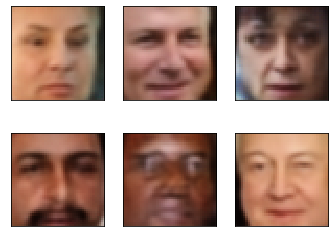

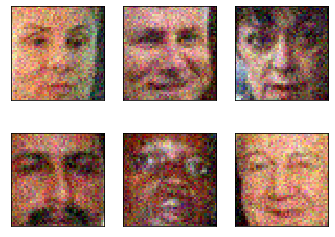

epoch: 50 out of 50
train_loss: 0.0015166966760531068	 val_loss:0.001838659235008708


In [ ]:
best_param, train_losses, val_losses = train(val_loader, train_loader, 50)

In [ ]:
torch.save(best_param.state_dict(), '/content/Autoencoder_noise.pth')
autoencoder.load_state_dict(torch.load('/content/Autoencoder_noise.pth'))

<All keys matched successfully>

# Bonus 4. (2+ балла)

Пишем телеграм-бота!

Можно написать телеграм-бота, которому на вход вы подаете, например, картинку без улыбки, а он вам возвращает с улыбкой.

Или еще много вариантов, чего может уметь делать бот. Придумайте сами)

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!